# Compare Flux Redshift data in delight simulation and input DESC

- Probaby I need to normalize the flux to the Delight simulation

- author : Sylvie Dagoret-Campagne

- affiliation : IJCLab/IN2P3/CNRS
- creation date : March 17th 2021
- update : April 3rd 2021
- last update : May 13th 2021
- last verification : January 4th 2022

data are in 

        ln -s ../tmp
        ln -s ../tmpsim
        
SED and FILTERS are at the relative place given in parameter file

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import sys
#from mpi4py import MPI
import numpy as np
from scipy.interpolate import interp1d
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP
from delight.photoz_kernels import Photoz_mean_function, Photoz_kernel
import scipy.stats
import matplotlib.pyplot as plt
#import emcee
#import corner
import logging
import coloredlogs

# Create a logger object.
logger = logging.getLogger(__name__)
coloredlogs.install(level='DEBUG', logger=logger,fmt='%(asctime)s,%(msecs)03d %(programname)s %(name)s[%(process)d] %(levelname)s %(message)s')

#comm = MPI.COMM_WORLD
#threadNum = comm.Get_rank()
#numThreads = comm.Get_size()

# Configuration

## The SED and the Flux Redshift model

In [3]:
files_sed_cww=["El_B2004a_fluxredshiftmod.txt","SB2_B2004a_fluxredshiftmod.txt","Sbc_B2004a_fluxredshiftmod.txt",
               "ssp_25Myr_z008_fluxredshiftmod.txt","Im_B2004a_fluxredshiftmod.txt","SB3_B2004a_fluxredshiftmod.txt",
               "Scd_B2004a_fluxredshiftmod.txt","ssp_5Myr_z008_fluxredshiftmod.txt"]

In [4]:
NSED=len(files_sed_cww)
NSED

8

## The simulation data

In [5]:
configsimfilename="tmpsim/parametersTest.cfg"

In [6]:
paramssim = parseParamFile(configsimfilename, verbose=True)

Input parameter file: tmpsim/parametersTest.cfg
Parameters read:
>  rootDir              ./
>  bands_directory      ../../rail/estimation/data/FILTER
>  bandNames            DC2LSST_u DC2LSST_g DC2LSST_r DC2LSST_i DC2LSST_z DC2LSST_y
>  templates_directory  ../../rail/estimation/data/SED
>  lambdaRef            4500.0
>  templates_names      El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
>  p_t                  [0.27   0.26   0.25   0.069  0.021  0.11   0.0061 0.0079]
>  p_z_t                [0.23 0.39 0.33 0.31 1.1  0.34 1.2  0.14]
>  training_numChunks   1
>  training_paramFile   ./tmpsim/delight_data/galaxies-gpparams.txt
>  training_catFile     ./tmpsim/delight_data/galaxies-fluxredshifts.txt
>  training_referenceBand DC2LSST_i
>  training_bandOrder   DC2LSST_u DC2LSST_u_var DC2LSST_g DC2LSST_g_var DC2LSST_r DC2LSST_r_var DC2LSST_i DC2LSST_i_var DC2LSST_z DC2LSST_z_var DC2LSST_y DC2LSST_y_var redshift
>  training_extraFracFluxError 0.00

## The DC2 data

In [7]:
configdatafilename="tmp/parametersTest.cfg"

In [8]:
paramsdata = parseParamFile(configdatafilename, verbose=True)

Input parameter file: tmp/parametersTest.cfg
Parameters read:
>  rootDir              ./
>  bands_directory      ../../rail/estimation/data/FILTER
>  bandNames            DC2LSST_u DC2LSST_g DC2LSST_r DC2LSST_i DC2LSST_z DC2LSST_y
>  templates_directory  ../../rail/estimation/data/SED
>  lambdaRef            4500.0
>  templates_names      El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
>  p_t                  [0.27   0.26   0.25   0.069  0.021  0.11   0.0061 0.0079]
>  p_z_t                [0.23 0.39 0.33 0.31 1.1  0.34 1.2  0.14]
>  training_numChunks   1
>  training_paramFile   ./tmp/delight_data/galaxies-gpparams.txt
>  training_catFile     ./tmp/delight_data/galaxies-fluxredshifts.txt
>  training_referenceBand DC2LSST_i
>  training_bandOrder   DC2LSST_u DC2LSST_u_var DC2LSST_g DC2LSST_g_var DC2LSST_r DC2LSST_r_var DC2LSST_i DC2LSST_i_var DC2LSST_z DC2LSST_z_var DC2LSST_y DC2LSST_y_var redshift
>  training_extraFracFluxError 0.0001
>  tra

# Decode parameters

In [9]:
DL = approx_DL()
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(paramssim)

In [10]:
numZ = redshiftGrid.size

# Read data flux Redshift for  the simulation

In [11]:
# Locate which columns of the catalog correspond to which bands.
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,refBandColumn = readColumnPositions(paramssim, prefix="training_")

# Read the model

- The Flux-Redshift model for each template is stored in the SED directory

In [12]:
dir_seds = paramssim['templates_directory']
dir_filters = paramssim['bands_directory']

In [13]:
lambdaRef = paramssim['lambdaRef']
sed_names = paramssim['templates_names']
numBands = bandIndices.size
nt = len(sed_names)

In [14]:
f_mod = np.zeros((numZ, nt, len(paramssim['bandNames'])))

In [15]:
# model of flux-redshift for each template
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')

## Read the simulation training Flux-Redshift dataset

- in Simulation mode, this file has been produced by **simulateWithSEDs(delightparamfile)** , ie **./tmpsim/delight_data/galaxies-fluxredshifts.txt**

In [16]:
numObjectsTraining = np.sum(1 for line in open(paramssim['training_catFile']))

/tmp/ipykernel_20223/3587500984.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(paramssim['training_catFile']))


In [17]:
numMetrics = 7 + len(paramssim['confidenceLevels'])

In [18]:
allFluxessim = np.zeros((numObjectsTraining, numBands))
allFluxesVarsim = np.zeros((numObjectsTraining, numBands))

redshiftssim = np.zeros((numObjectsTraining, 1))
fmod_atZsim = np.zeros((numObjectsTraining, nt, numBands))

ellsim= np.zeros(numObjectsTraining)

In [19]:
# Now loop over training set to compute likelihood function
loc = - 1
trainingDataIter = getDataFromFile(paramssim, 0, numObjectsTraining,prefix="training_", getXY=False)

In [20]:
# loop on training
for z, ell, bands, fluxes, fluxesVar, bCV, fCV, fvCV in trainingDataIter:
   
    loc += 1
    
    ellsim[loc] =ell

    allFluxessim[loc, :] = fluxes
    allFluxesVarsim[loc, :] = fluxesVar
    redshiftssim[loc, 0] = z
    
    # loop on SED
    for t, sed_name in enumerate(sed_names):
        for ib, b in enumerate(bands):
            fmod_atZsim[loc, t, ib] = ell * np.interp(z, redshiftGrid,f_mod[:, t, b])

# Luminosity Factor

Text(0.5, 1.0, 'Normalisation factor $\\ell$ for luminosity in sim')

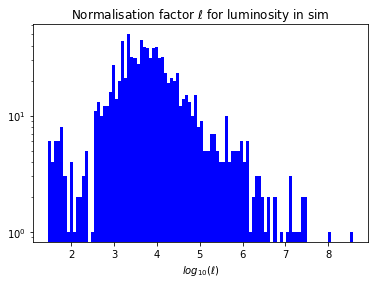

In [21]:
plt.hist(np.log10(ellsim),bins=100,facecolor="b");
plt.yscale("log")
plt.xlabel("$log_{10}(\ell$)")
plt.title("Normalisation factor $\ell$ for luminosity in sim")

In [22]:
ellsim_mean=ellsim.mean()

In [23]:
ellsim_mean

800730.3008869187

# Compare SED model with Flux-Redshift data in simulation

Text(0.5, 1.01, 'Delight Simulation : Flux-Redshift model comparison between model and simulated data')

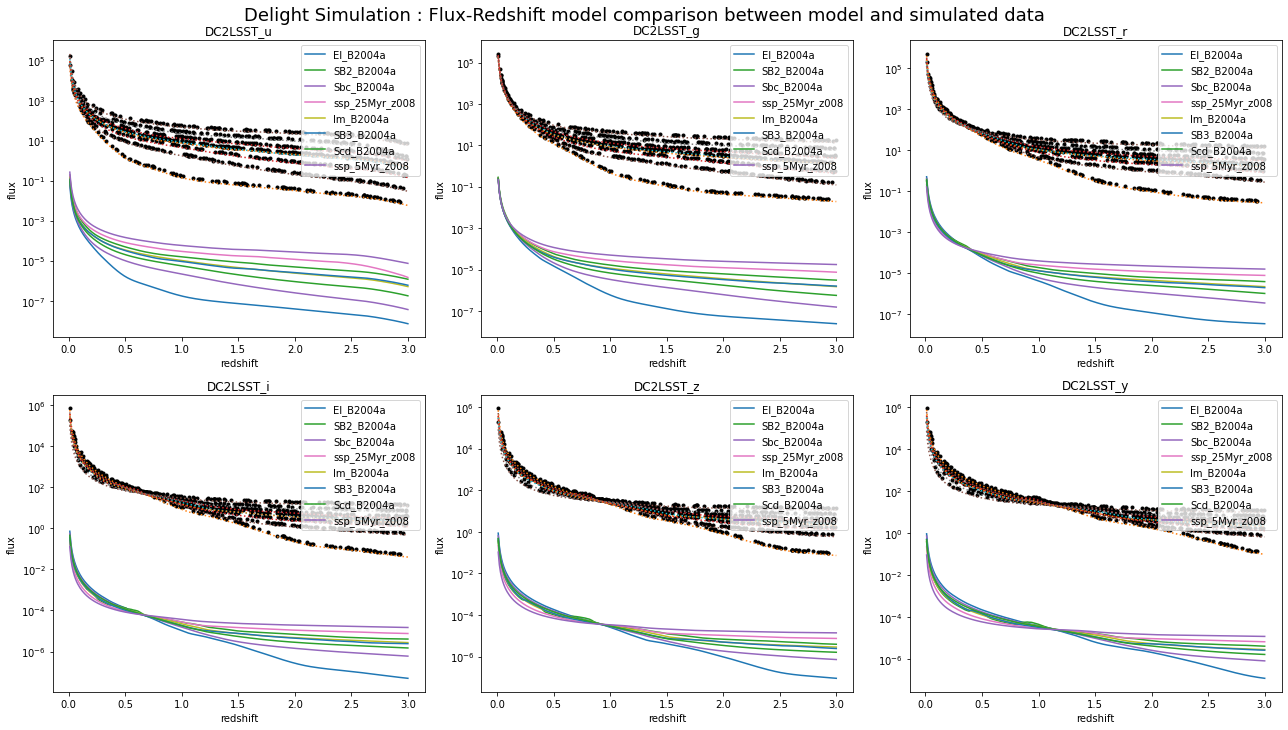

In [25]:
ncol=3
nrow=2
fig, axes = plt.subplots(nrow, ncol,figsize=(18,10)) 

for ised in np.arange(NSED):
    filename=files_sed_cww[ised]
    sedname=filename.split("_fluxredshiftmod")[0]
    fullfilename=os.path.join(dir_seds,filename)
    flux=np.loadtxt(fullfilename)
    for ifilt in np.arange(6):
        
        iy=ifilt//3
        ix=ifilt-iy*3
        
        #ix=ifilt//2
        #iy=ifilt-ix*2
        
        axes[iy,ix].plot(redshiftGrid,flux[:,ifilt],label=sedname)
        axes[iy,ix].plot(redshiftGrid,ellsim_mean*flux[:,ifilt],":")
        axes[iy,ix].legend(loc="upper right")
        if ised==0:
            axes[iy,ix].set_yscale("log")
            axes[iy,ix].set_title(bandNames[ifilt])
            axes[iy,ix].set_xlabel("redshift")
            axes[iy,ix].set_ylabel("flux")
            axes[iy,ix].scatter(redshiftssim[:, 0],allFluxessim[:, ifilt],marker=".",color="k" )
            
plt.tight_layout() 
plt.suptitle("Delight Simulation : Flux-Redshift model comparison between model and simulated data",fontsize=18,y=1.01)


## Check normalisation

Text(0.5, 1.01, 'Delight Simulation : Flux-Redshift model comparison between rescaled model and simulated data')

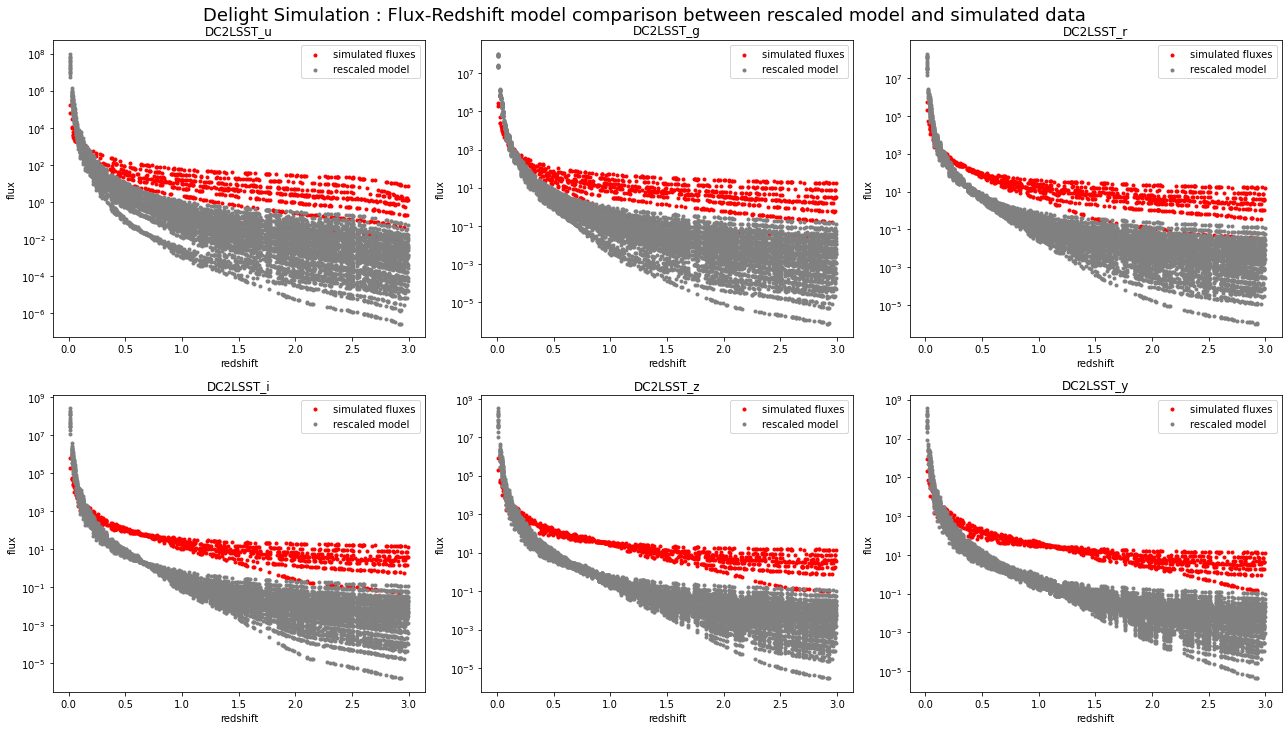

In [26]:
ncol=3
nrow=2
fig, axes = plt.subplots(nrow, ncol,figsize=(18,10)) 


for ifilt in np.arange(6):
    #ix=ifilt//2
    #iy=ifilt-ix*2
    
    iy=ifilt//3
    ix=ifilt-iy*3
        
    
    axes[iy,ix].scatter(redshiftssim[:, 0],allFluxessim[:, ifilt],marker=".",color="r",label="simulated fluxes" )
    
    for t, sed_name in enumerate(sed_names): 
        if t==0:
            axes[iy,ix].scatter(redshiftssim[:, 0],fmod_atZsim[:, t,ifilt],marker='.',color='grey',label="rescaled model")
        else:
            axes[iy,ix].scatter(redshiftssim[:, 0],fmod_atZsim[:, t,ifilt],marker='.',color='grey')
    
    #axes[iy,ix].legend(loc="upper right")
    
    axes[iy,ix].set_yscale("log")
    axes[iy,ix].set_title(bandNames[ifilt])
    axes[iy,ix].set_xlabel("redshift")
    axes[iy,ix].set_ylabel("flux")
    axes[iy,ix].legend()
    
plt.tight_layout() 
plt.suptitle("Delight Simulation : Flux-Redshift model comparison between rescaled model and simulated data",fontsize=18,y=1.01)

    
            

## Read the DESC-DC3 Flux Redshift

In [27]:
numObjectsTraining = np.sum(1 for line in open(paramsdata['training_catFile']))

/tmp/ipykernel_20223/91789096.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(paramsdata['training_catFile']))


In [28]:
numMetrics = 7 + len(paramsdata['confidenceLevels'])

In [29]:
allFluxesdata = np.zeros((numObjectsTraining, numBands))
allFluxesVardata = np.zeros((numObjectsTraining, numBands))

redshiftsdata = np.zeros((numObjectsTraining, 1))
fmod_atZdata = np.zeros((numObjectsTraining, nt, numBands))

elldata= np.zeros(numObjectsTraining)

In [30]:
# Now loop over training set to compute likelihood function
loc = - 1
trainingDataIter = getDataFromFile(paramsdata, 0, numObjectsTraining,prefix="training_", getXY=False)

In [31]:
# loop on traning

for z, ell, bands, fluxes, fluxesVar, bCV, fCV, fvCV in trainingDataIter:
   
    loc += 1
    
    elldata[loc] =ell

   
    allFluxesdata[loc, :] = fluxes
    allFluxesVardata[loc, :] = fluxesVar
    redshiftsdata[loc, 0] = z
    
    # loop on SED
    for t, sed_name in enumerate(sed_names):
        for ib, b in enumerate(bands):
            fmod_atZdata[loc, t, ib] = ell * np.interp(z, redshiftGrid,f_mod[:, t, b])

### Normalisation factor distribution

Text(0.5, 1.0, 'Normalisation factor $\\ell$ for luminosity in desc data')

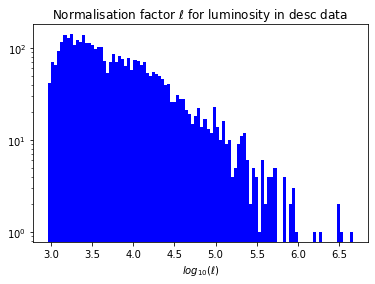

In [32]:
plt.hist(np.log10(elldata),bins=100,facecolor="b");
plt.yscale("log")
plt.xlabel("$log_{10}(\ell$)")
plt.title("Normalisation factor $\ell$ for luminosity in desc data")

In [33]:
elldata_mean=elldata.mean()

In [34]:
elldata_mean

24558.721284558374

Text(0.5, 1.01, 'Delight with DC2 : Flux-Redshift model comparison between model and simulated data')

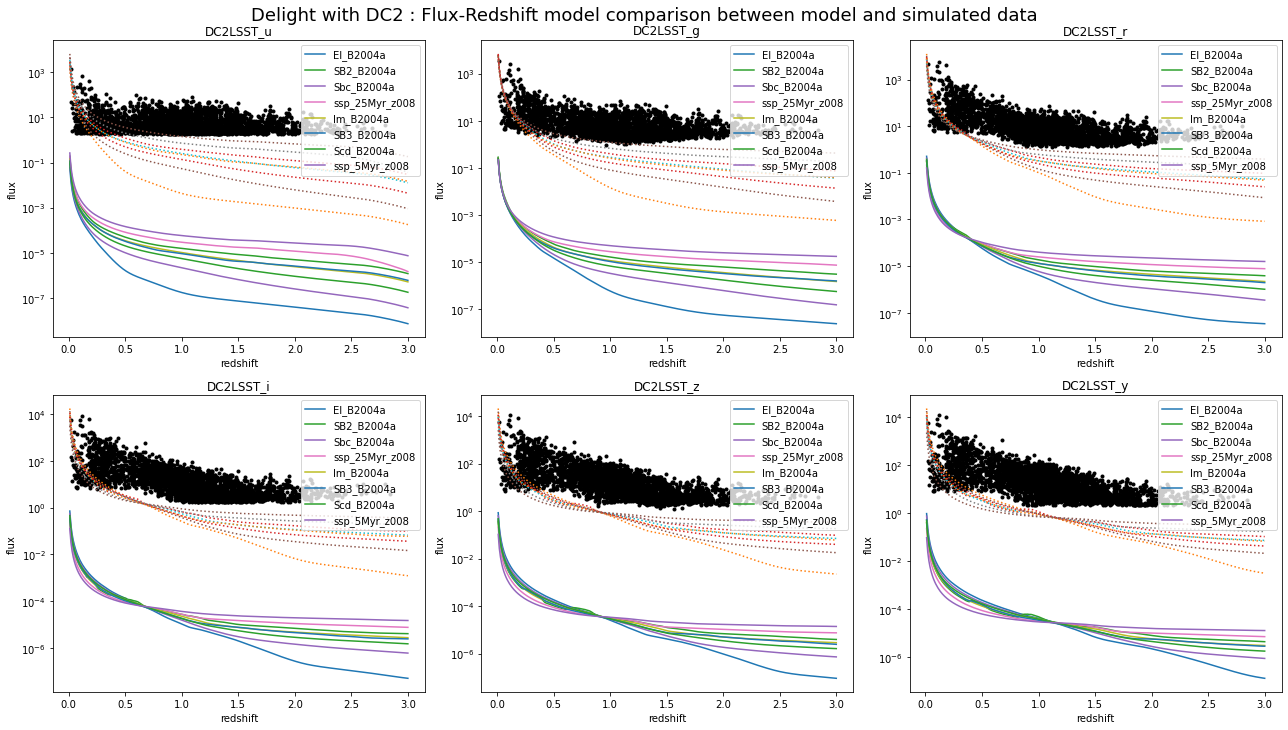

In [36]:
ncol=3
nrow=2
fig, axes = plt.subplots(nrow, ncol,figsize=(18,10)) 

for ised in np.arange(NSED):
    filename=files_sed_cww[ised]
    sedname=filename.split("_fluxredshiftmod")[0]
    fullfilename=os.path.join(dir_seds,filename)
    flux=np.loadtxt(fullfilename)
    for ifilt in np.arange(6):
        #ix=ifilt//2
        #iy=ifilt-ix*2
        
        iy=ifilt//3
        ix=ifilt-iy*3
        
        axes[iy,ix].plot(redshiftGrid,flux[:,ifilt],label=sedname)
        axes[iy,ix].plot(redshiftGrid,elldata_mean *flux[:,ifilt],":")
        axes[iy,ix].legend(loc="upper right")
        if ised==0:
            axes[iy,ix].set_yscale("log")
            axes[iy,ix].set_title(bandNames[ifilt])
            axes[iy,ix].set_xlabel("redshift")
            axes[iy,ix].set_ylabel("flux")
            axes[iy,ix].scatter(redshiftsdata[:, 0],allFluxesdata[:, ifilt],marker=".",color="k" )
            
plt.tight_layout()    

plt.tight_layout() 
plt.suptitle("Delight with DC2 : Flux-Redshift model comparison between model and simulated data",fontsize=18,y=1.01)


### Check Normalisation

Text(0.5, 1.01, 'Delight with DC2 : Flux-Redshift model comparison between rescaled model and DC2 data')

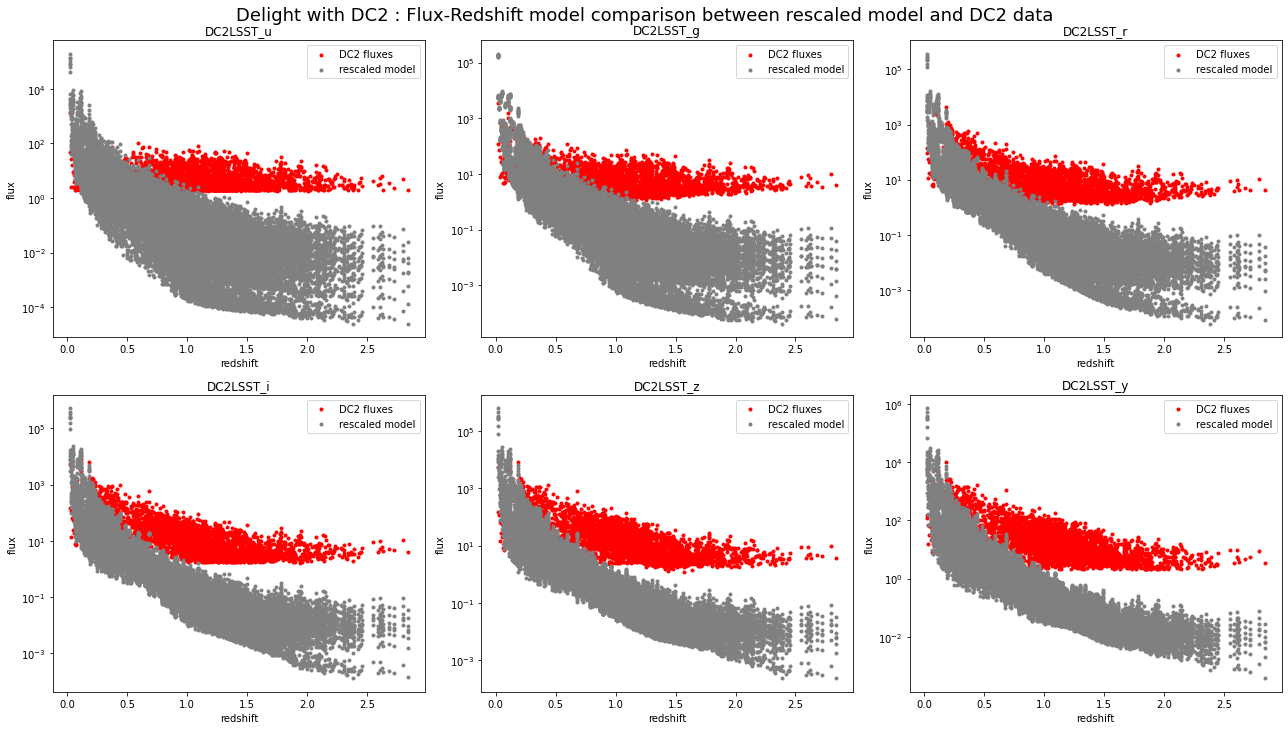

In [37]:
ncol=3
nrow=2
fig, axes = plt.subplots(nrow, ncol,figsize=(18,10)) 


for ifilt in np.arange(6):
    #ix=ifilt//2
    #iy=ifilt-ix*2
    
    iy=ifilt//3
    ix=ifilt-iy*3
        
    
    axes[iy,ix].scatter(redshiftsdata[:, 0],allFluxesdata[:, ifilt],marker=".",color="r",label="DC2 fluxes")
    
    for t, sed_name in enumerate(sed_names): 
        if t==0:
            axes[iy,ix].scatter(redshiftsdata[:, 0],fmod_atZdata[:, t,ifilt],marker='.',color='grey',label="rescaled model")
        else:
            axes[iy,ix].scatter(redshiftsdata[:, 0],fmod_atZdata[:, t,ifilt],marker='.',color='grey')
                 
    
    #axes[iy,ix].legend(loc="upper right")
    
    axes[iy,ix].set_yscale("log")
    axes[iy,ix].set_title(bandNames[ifilt])
    axes[iy,ix].set_xlabel("redshift")
    axes[iy,ix].set_ylabel("flux")
    axes[iy,ix].legend()
       
plt.tight_layout() 
plt.suptitle("Delight with DC2 : Flux-Redshift model comparison between rescaled model and DC2 data",fontsize=18,y=1.01)
